In [1]:
import os
import sys

# spark imports
from pyspark.sql import SparkSession

# Environment variables for PySpark
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession \
    .builder \
    .appName("Collaborative Filtering-Based Recommendation System Pipeline") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()

# Load the datasets as Spark DataFrames
posts_df = spark.read.csv('datasets/post_data.csv', header=True, inferSchema=True)
views_df = spark.read.csv('datasets/view_data.csv', header=True, inferSchema=True)
users_df = spark.read.csv('datasets/user_data.csv', header=True, inferSchema=True)

## 2. Data Pre-processing
### 2.1. Generate Score Data

In [2]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

import numpy as np

# Generate random probabilities for scores 1, 2, and 3 using NumPy
probs = np.random.dirichlet(np.ones(3))
score_choices = [1, 2, 3]

# Broadcast the probabilities and score choices
probs_broadcast = spark.sparkContext.broadcast(probs)
score_choices_broadcast = spark.sparkContext.broadcast(score_choices)

# Define a UDF to assign scores based on probabilities
def generate_score():
    return int(np.random.choice(score_choices_broadcast.value, p=probs_broadcast.value))

generate_score_udf = udf(generate_score, IntegerType())

# Add the score column to the views_df DataFrame to create interactions_df
interactions_df = views_df.withColumn("score", generate_score_udf())

# Show the resulting DataFrame
interactions_df.show(5)

+--------------------+---------+-------------------+-----+
|             user_id|  post_id|         time_stamp|score|
+--------------------+---------+-------------------+-----+
|5eece14ffc13ae660...|136781766|01/01/2019 01:30 PM|    3|
|5eece14efc13ae660...| 43094523|01/01/2019 01:33 PM|    3|
|5eece14efc13ae660...| 42428071|01/01/2019 01:43 PM|    2|
|5eece14ffc13ae660...| 76472880|01/01/2019 01:54 PM|    2|
|5eece14ffc13ae660...|202721843|01/01/2019 02:00 PM|    1|
+--------------------+---------+-------------------+-----+
only showing top 5 rows



### 2.2. Data Cleaning and Transformation for Model Training

In [3]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer

# Select only the necessary columns ["userId", "postId", "score"]
interactions_df = interactions_df.select("user_id", "post_id", "score")

# Remove duplicates from the interactions DataFrame
interactions_df = interactions_df.dropDuplicates()

# Use StringIndexer to convert 'user_id' to numeric value
indexer = StringIndexer(inputCol="user_id", outputCol="user_id_numeric")
interactions_df = indexer.fit(interactions_df).transform(interactions_df)

# Convert 'post_id' to numeric value using StringIndexer
post_indexer = StringIndexer(inputCol="post_id", outputCol="post_id_numeric")
interactions_df = post_indexer.fit(interactions_df).transform(interactions_df)

# Convert the 'score' column to double type
interactions_df = interactions_df \
    .withColumn("score", col("score").cast("double"))

### 2.3. Splitting Data Into Train, Validation and Test Sets

In [4]:
# Split the interactions DataFrame into 60% train, 20% validation, and 20% test
train, validation, test = interactions_df.randomSplit([0.6, 0.2, 0.2], seed=99)

# Cache the datasets
train.cache()
validation.cache()
test.cache()

DataFrame[user_id: string, post_id: int, score: double, user_id_numeric: double, post_id_numeric: double]

## 3. MODEL TRAINING AND EVALUATION
### 3.1. ALS Hyperparameters Tuning Using Grid Search

In [5]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

# Function to tune the ALS model by finding the optimal rank and regularization parameters using the Grid Search technique
def tune_ALS(train_data, validation_data, max_iters, regularization_params, ranks):
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    als = ALS(
            userCol='user_id_numeric',
            itemCol='post_id',
            ratingCol='score',
            coldStartStrategy="drop" , nonnegative = True)
    
    for rank in ranks:
        for reg in regularization_params:
            # get ALS model
            als.setMaxIter(max_iters).setRank(rank).setRegParam(reg)
            # train ALS model
            model = als.fit(train_data)
            # evaluate the model by computing the RMSE on the validation data
            predictions = model.transform(validation_data)
            evaluator = RegressionEvaluator(metricName="rmse",
                                            labelCol="score",
                                            predictionCol="prediction")
            rmse = evaluator.evaluate(predictions)
            print(f"Rank: {rank} and Regularization: {reg} | Validation RMSE: {rmse:.4f}")
            if rmse < min_error:
                min_error = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
    
    print(f"\nBest Model: {best_rank} latent factors with regularization: {best_regularization}")
    return best_model

# Define the hyperparameters
max_iters = 10
regularization_params = [0.01, 0.05, 0.1, 0.2, 0.5]
ranks = [5, 10, 20, 30, 40, 50]

# Start the hyperparameter tuning process
best_model = tune_ALS(train, validation, max_iters, regularization_params, ranks)

Rank: 5 and Regularization: 0.01 | Validation RMSE: 0.9406
Rank: 5 and Regularization: 0.05 | Validation RMSE: 0.8778
Rank: 5 and Regularization: 0.1 | Validation RMSE: 0.8300
Rank: 5 and Regularization: 0.2 | Validation RMSE: 0.7921
Rank: 5 and Regularization: 0.5 | Validation RMSE: 0.8813
Rank: 10 and Regularization: 0.01 | Validation RMSE: 0.9983
Rank: 10 and Regularization: 0.05 | Validation RMSE: 0.8977
Rank: 10 and Regularization: 0.1 | Validation RMSE: 0.8350
Rank: 10 and Regularization: 0.2 | Validation RMSE: 0.7937
Rank: 10 and Regularization: 0.5 | Validation RMSE: 0.8813
Rank: 20 and Regularization: 0.01 | Validation RMSE: 1.0360
Rank: 20 and Regularization: 0.05 | Validation RMSE: 0.9068
Rank: 20 and Regularization: 0.1 | Validation RMSE: 0.8400
Rank: 20 and Regularization: 0.2 | Validation RMSE: 0.7959
Rank: 20 and Regularization: 0.5 | Validation RMSE: 0.8813
Rank: 30 and Regularization: 0.01 | Validation RMSE: 1.0560
Rank: 30 and Regularization: 0.05 | Validation RMSE: 0

# ALS model learning curve

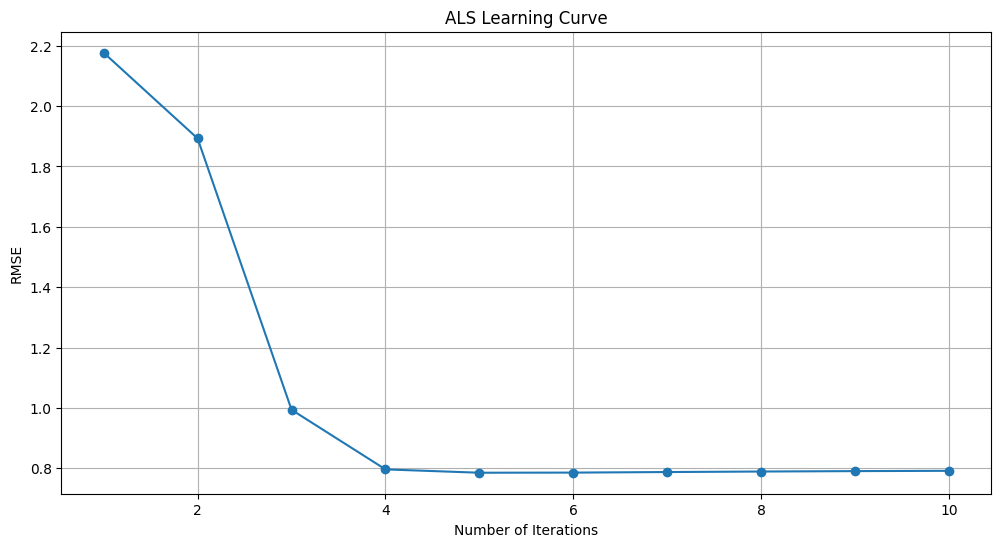

In [8]:
import math
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.appName("ALS_Learning_Curve").getOrCreate()

# Function to plot the learning curve of the ALS model
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []

    for num_iters in arr_iters:
        # Create ALS model
        als = ALS(
            maxIter=num_iters,
            rank=rank,
            regParam=reg,
            userCol="user_id_numeric",
    itemCol="post_id_numeric",
            ratingCol="score",
            coldStartStrategy="drop"  # Ensures no NaN predictions
        )

        # Train ALS model
        model = als.fit(train_data)

        # Make predictions on validation data
        predictions = model.transform(validation_data)

        # Calculate RMSE
        predictions = predictions.withColumn("error", (col("score") - col("prediction")) ** 2)
        mse = predictions.select("error").rdd.map(lambda row: row[0]).mean()
        rmse = math.sqrt(mse)

        # Add RMSE to errors
        errors.append(rmse)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors, marker='o')
    plt.xlabel("Number of Iterations")
    plt.ylabel("RMSE")
    plt.title("ALS Learning Curve")
    plt.grid(True)
    plt.show()
    
# Create the learning curve plot
iter_array = list(range(1, 11))
plot_learning_curve(iter_array, train, validation, 0.2, 5)

After the 4th iteration, the alternating gradient descent in the ALS model begins to converge, stabilizing around an error of 0.8.